In [98]:
import pandas as pd
import zipfile 
import pandas as pd
import numpy as np
import os
import sys
import pylab as pl
import geopandas as gpd
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt

from matplotlib import cm
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
import matplotlib.patches as mpatches
from descartes import PolygonPatch

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

In [18]:
!for ((y=94; y<=99; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp$y\totals.zip; done

!for ((y=0; y<=1; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0$y\totals.zip; done

!for ((y=2; y<=9; y+=1)); do wget \
https://www2.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=10; y<=14; y+=1)); do wget \
https://www2.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

--2017-12-12 19:26:14--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp94totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:288::208c, 2600:141b:13:295::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611524 (597K) [application/zip]
Saving to: “zbp94totals.zip”

100%[======================================>] 611,524     --.-K/s   in 0.1s    

2017-12-12 19:26:14 (5.01 MB/s) - “zbp94totals.zip” saved [611524/611524]

--2017-12-12 19:26:15--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp95totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:288::208c, 2600:141b:13:295::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625328 (611K) [application/zip]
Saving to: “zbp95totals.zip”

100%[======================================>] 625,328     --.-K/s   in 0.06s   

2017-12-12 19:26:15 (9.

In [19]:
PUIDATA = os.getenv('PUIDATA')
print(PUIDATA)

/home/cusp/nn1221/PUIdata


In [30]:
path = PUIDATA + '/HW11_nn1221/'

if (not os.path.isdir(path)):
    if (os.system('mkdir ' + path) == 0):
        print("OK, directory in place")
else:
    print("Directory "+ path +" in place")

Directory /home/cusp/nn1221/PUIdata/HW11_nn1221/ in place


In [21]:
df = pd.DataFrame()
years = range(1994,2015)

## You can use zipfile module in python to unzip the files
it should be install in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands, and miss the chance to learn something new)

In [25]:
 for year in years:
    yr = str(year)[2:4]
    filename = 'zbp' + yr + 'totals.zip'
    if not os.path.isfile(path + filename):
        print("File not found for " + filename)
        print("Move file " + filename)
        os.system('mv ' + filename + ' ' + path)
    
    if os.path.isfile(path + filename):
        print("File " + filename + " in place, unzip file...")
        print(path + filename)
        zf = zipfile.ZipFile(path + filename) 
        print("Unzip " + filename + " is done, now read tha data...")
        print(zf.namelist())
        filenametxt = zf.namelist()[0]
        zbp = pd.read_csv(zf.open(filenametxt))
        print("Formatting file " + filenametxt)
        zbp.columns = [x.upper() for x in zbp.columns]
        zbp['YEAR'] = year
        zbp = zbp.loc[:,['ZIP','EST','YEAR']]
        print("Finish formatting file " + filename + ". Now, append to single dataframe")
        df = df.append(zbp)
        print(str(df.shape) + "\n")
print(df.shape)

File zbp94totals.zip in place, unzip file...
/home/cusp/nn1221/PUIdata/HW11_nn1221/zbp94totals.zip
Unzip zbp94totals.zip is done, now read tha data...
['zbp94totals.txt']
Formatting file zbp94totals.txt
Finish formatting file zbp94totals.zip. Now, append to single dataframe
(39259, 3)

File not found for zbp95totals.zip
Move file zbp95totals.zip
File zbp95totals.zip in place, unzip file...
/home/cusp/nn1221/PUIdata/HW11_nn1221/zbp95totals.zip
Unzip zbp95totals.zip is done, now read tha data...
['zbp95totals.txt']
Formatting file zbp95totals.txt
Finish formatting file zbp95totals.zip. Now, append to single dataframe
(79191, 3)

File not found for zbp96totals.zip
Move file zbp96totals.zip
File zbp96totals.zip in place, unzip file...
/home/cusp/nn1221/PUIdata/HW11_nn1221/zbp96totals.zip
Unzip zbp96totals.zip is done, now read tha data...
['zbp96totals.txt']
Formatting file zbp96totals.txt
Finish formatting file zbp96totals.zip. Now, append to single dataframe
(119290, 3)

File not found f

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


In [31]:
shp_url = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
shp_fname = 'application%2Fzip'

In [32]:
if not os.path.isdir(PUIDATA + '/ZIPCODE_SHP'):
    print('Download file ' + shp_fname)
    os.system('wget ' + shp_url)
    print('Move file ' + shp_fname)
    os.system('mv ' + shp_fname + ' ' + PUIDATA)
    print('Unzip file ' + shp_fname)
    os.system("unzip " + PUIDATA + "/" + shp_fname + " -d " + PUIDATA + '/ZIPCODE_SHP')
    print('Done unzipping file ' + shp_fname)

if os.path.isdir(PUIDATA + '/ZIPCODE_SHP'):
    for file in os.listdir(PUIDATA + '/ZIPCODE_SHP'):
        if file.endswith('.shp'):
            print('Shapefile in place')
            NYCshp = file

Download file application%2Fzip
Move file application%2Fzip
Unzip file application%2Fzip
Done unzipping file application%2Fzip
Shapefile in place


In [39]:
NYC_shp = gpd.GeoDataFrame.from_file(PUIDATA + '/ZIPCODE_SHP/' + NYCshp)
NYC_shp = NYC_shp[['ZIPCODE', 'geometry']]
NYC_shp['ZIPCODE'] = NYC_shp.ZIPCODE.astype(int)
NYC_shp.head(2)

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."


# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: we talked about the importance of "whitening" your data.
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
1. get and prep your data.
2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
4. Use another clustering algorithm (of your choice)
5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
6. Compare the results of the 2 algorithms
7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

## 1. get and prep your data.

In [49]:
df.columns

Index(['ZIP', 'EST', 'YEAR'], dtype='object')

In [68]:
# remove NaNs
df_NY = df.copy()
df_NY = df_NY.dropna(subset=["ZIP"])
# convert ZIP and YEAR as int
df_NY['ZIP'] = df_NY['ZIP'].astype(int)
df_NY['YEAR'] = df_NY['YEAR'].astype(int)

In [69]:
# create pivot table
df_pivot = df_NY.pivot_table(index='ZIP', columns='YEAR', values='EST')
df_pivot.head()

YEAR,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIP,,,,,,,,,,,,,,,,,,,,,
501,NaN,2.0,4.0,4.0,3.0,2.0,1.0,6.0,11.0,7.0,...,2.0,8.0,5.0,3.0,2.0,2.0,2.0,2.0,2.0,4.0
1000,NaN,4.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,505.0,...,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0,458.0
1002,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,586.0,...,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0,560.0
1003,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,16.0,...,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0,18.0


In [66]:
df_pivot.shape

(42671, 21)

In [70]:
df_pivot.dropna(axis=0, inplace=True)

In [75]:
NYC_pivot = NYC_shp.merge(df_pivot, right_index=True, left_on='ZIPCODE')
NYC_pivot.set_index('ZIPCODE', inplace=True)
NYC_pivot.drop('geometry', axis=1, inplace=True)
NYC_pivot.head(1)

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0


In [78]:
NYC_standarized = ((NYC_pivot.T - NYC_pivot.mean(axis=1)) / NYC_pivot.std(axis=1)).T
NYC_standarized.head(1)

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,-1.296083,-1.34734,-1.193568,-1.296083,-1.296083,-0.93728,-0.578478,-0.988538,0.08787,-0.11716,...,0.2929,0.190385,0.395415,0.70296,0.805475,1.11302,1.266793,0.959248,1.164278,1.676853


## 2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)

In [86]:
# Code from Applied Data Science class by Prof. Stanislav Sobolevsky
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid 
    # since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

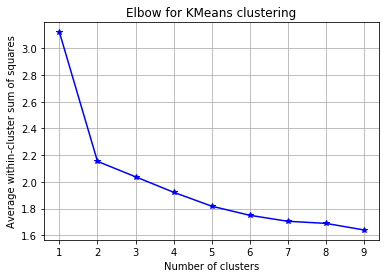

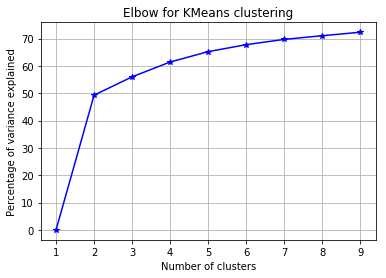

In [94]:
elbow(NYC_standarized, range(1,10))

**Fig 1.** Elbow for KMeans clustering.

The elbow method shows the best cluster 1 cluster, but because the professor ask for more than couple but still in a 
single digit, so I proceed with silhouette score

In [91]:
range_n_clusters = [3, 4, 5, 6, 7, 8, 9]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(NYC_standarized)
    silhouette_avg = silhouette_score(NYC_standarized, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" 
          the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =3, the average silhouette_score is :0.5384936002679283
For n_clusters =4, the average silhouette_score is :0.4973510432038974
For n_clusters =5, the average silhouette_score is :0.3238831914709611
For n_clusters =6, the average silhouette_score is :0.264900516168676
For n_clusters =7, the average silhouette_score is :0.23539943896331056
For n_clusters =8, the average silhouette_score is :0.2352605655144018
For n_clusters =9, the average silhouette_score is :0.19742737243298955


Well, because the average silhouette_score distance between 4 is closer to 3 than 5 clusters, I then choose 4 clusters.

In [95]:
# K-means cluster
n = 4
km = KMeans(n).fit(NYC_standarized)
NYC_standarized['kmeans'] = km.labels_

## 3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).



In [105]:
# store K-means cluster center to pandas DataFrame for plotting
centersKM = pd.DataFrame(km.cluster_centers_)
centersKM.columns = NYC_standarized.columns[:-2]
# new merge df for plotting
center_cluster = NYC_shp.merge(NYC_standarized, left_on='ZIPCODE', right_index=True)

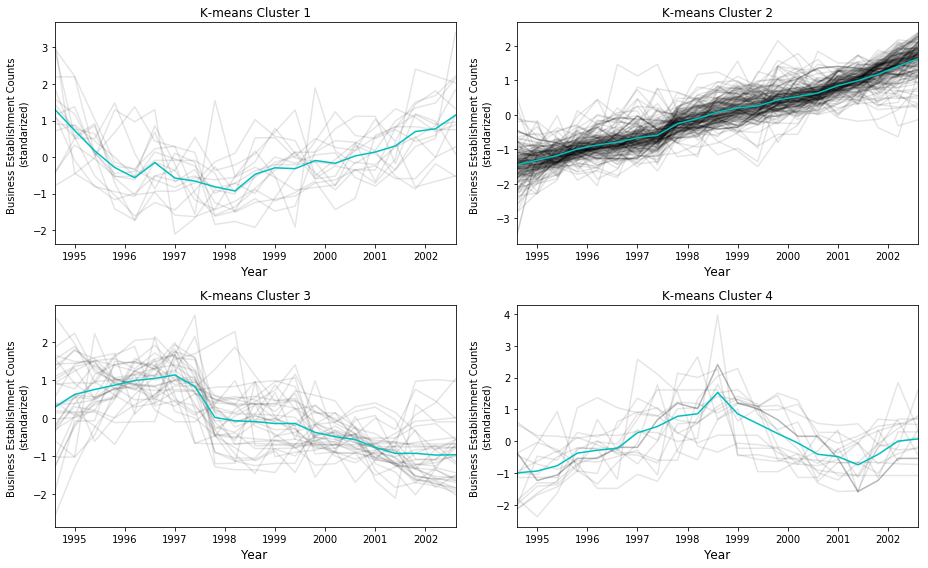

In [112]:
# plot k-means
fig = pl.figure(figsize=(13,8))
for i in range(n):
    ax = fig.add_subplot(2,2,i+1)
    cluster = NYC_standarized[NYC_standarized['kmeans'] == i]
    ax.plot(cluster.iloc[:,:-2].T, c='k', alpha=0.1)
    ax.plot(centersKM.iloc[i], c='c')
    ax.set_xticklabels(cluster.columns[:-2])
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Business Establishment Counts \n(standarized)', fontsize=10)
    ax.set_title("K-means Cluster {}".format(str(i+1)))
    ax.set_xlim([1994,2014])
pl.tight_layout()

**Fig 2.** K-Means clustering plot of business establishment in New York City

The k-means center shows different trend according to each cluster.

## 4. Use another clustering algorithm (of your choice)

In [120]:
# I used hierarchical clustering
h_clustering = NYC_standarized.iloc[:, 0:21]
links = linkage(h_clustering, 'ward')

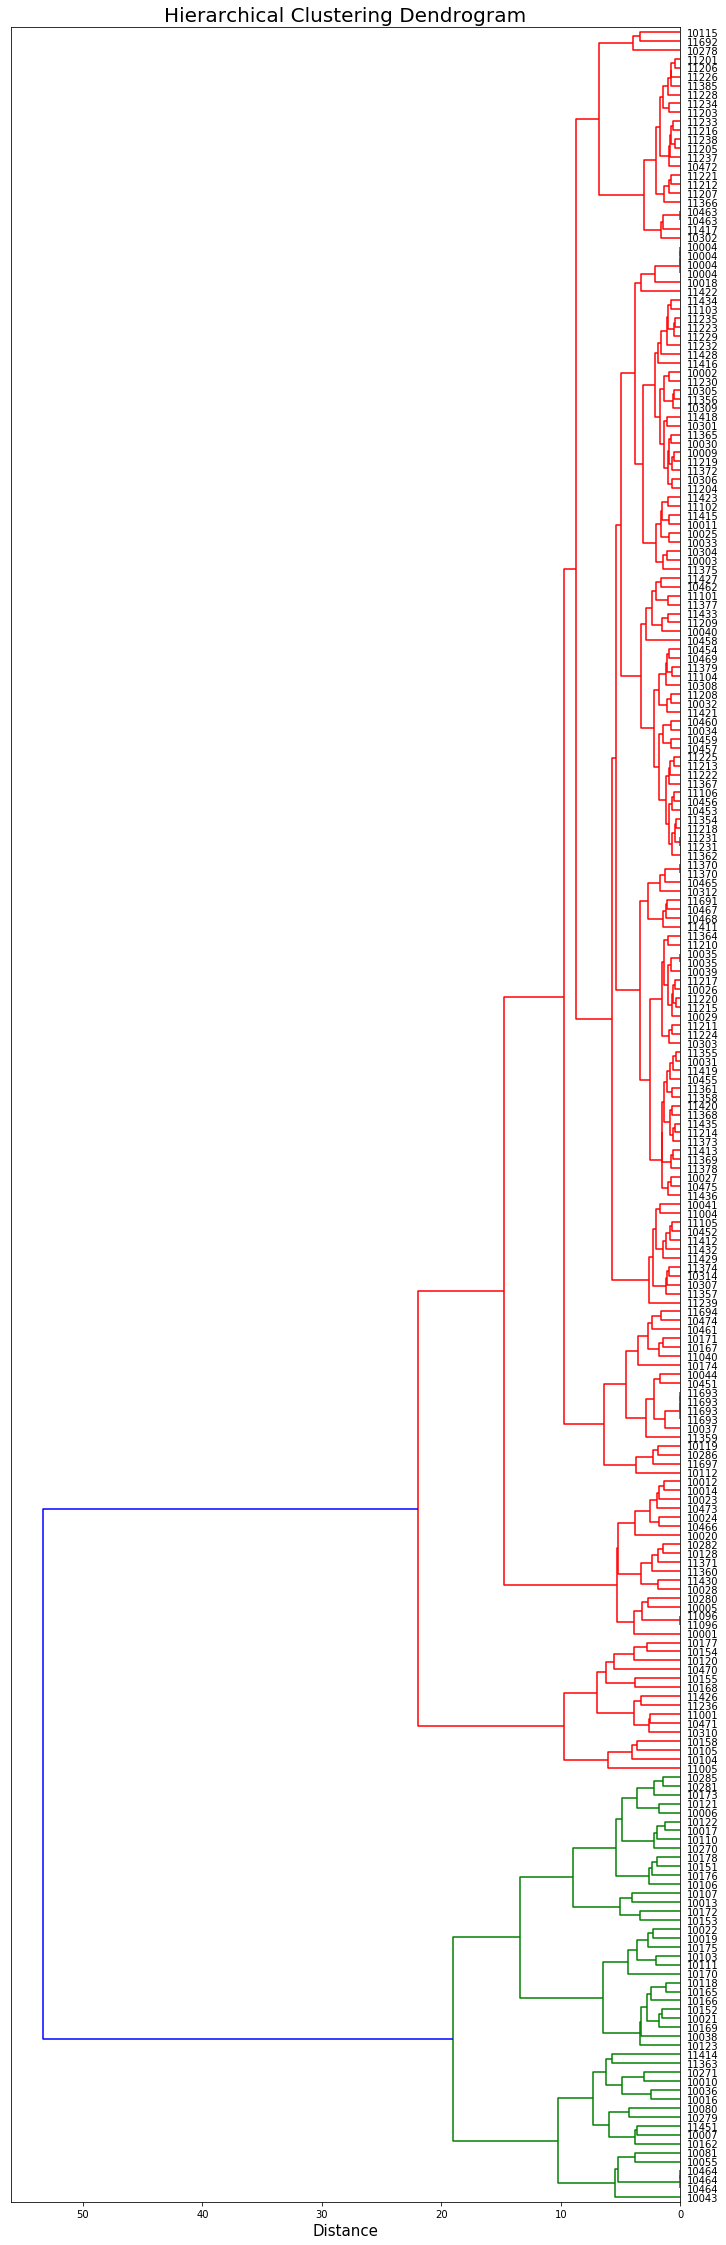

In [135]:
# plot dendrogram
plt.figure(figsize=(12, 40))
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.xlabel('Distance', fontsize=15)
dendrogram(links, leaf_font_size=10, orientation='left', labels=h_clustering.index)
plt.show()

**Fig 3.** Hierarchical clustering plot of business establishment in New York City

The hierarchical cluster shows 2 main clusters with the colof of green and red.

## 5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters

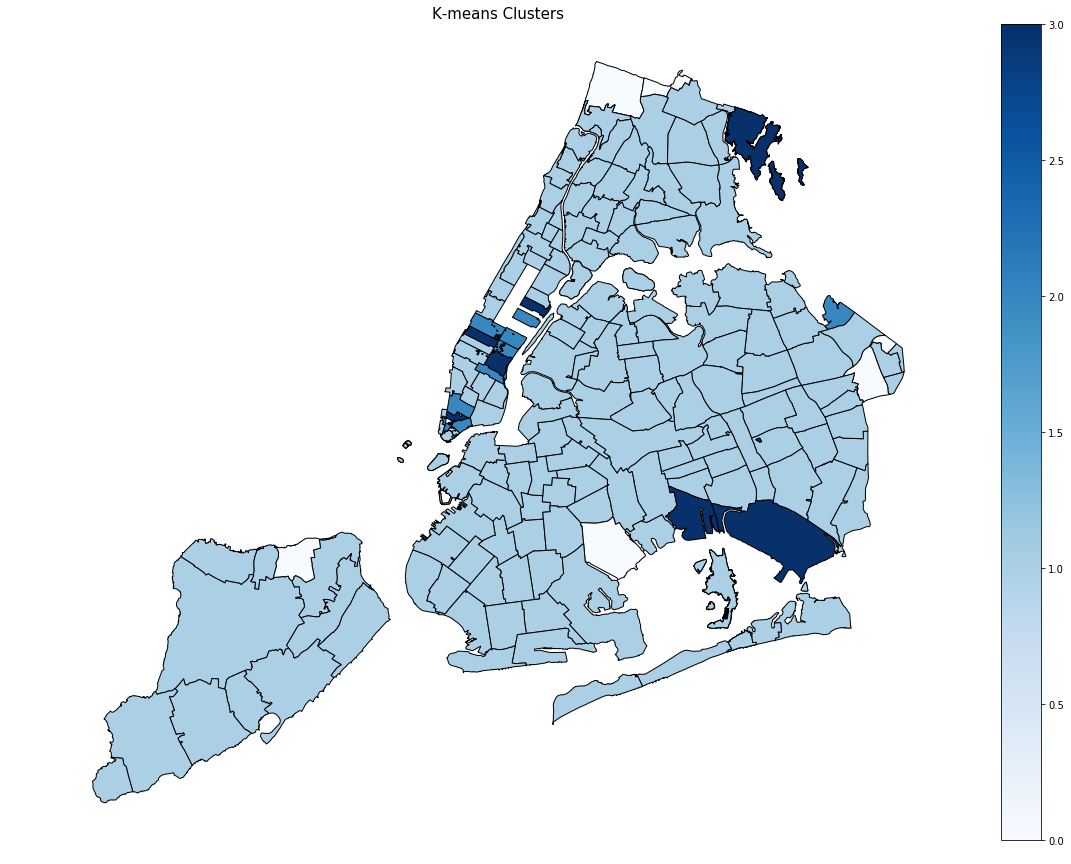

In [133]:
fig2 = pl.figure(figsize=(20,15))
ax2 = fig2.add_subplot(111)
center_cluster.plot(ax=ax2, column='kmeans', cmap='Blues', edgecolor='k', lw=1, legend=True)
ax2.set_title('K-means Clusters', fontsize=15)
ax2.axis('off');

**Fig 4.** K-means clustering map of business establishment in New York City (cluster = 4)

Each color represent different cluster. The cluster divided by most of NYC, Midtown 1, Midtown 2 and JFK, and the ones that far from downtown. 

In [159]:
# hierarchical
k = 4
NYC_standarized['hierarchical'] = fcluster(links, k, criterion='maxclust')
h_label = pd.DataFrame(NYC_standarized['hierarchical']).reset_index()
h_shp = pd.merge(NYC_shp,h_label, how='left', on='ZIPCODE')
h_shp.fillna(0, inplace=True)

In [163]:
def plot_cluster(column_cluster, n_cluster, desired_axis):    
    def getColorIndex(column_cluster, iter_number):
        '''This function is to get color index from cmap'''
        if (column_cluster == 'hierarchical'):
            color_index = int(h_shp[column_cluster][iter_number])
        else:
            color_index = int(h_shp[column_cluster][iter_number]+1)
        return color_index
    
    ax = desired_axis
    colors = np.linspace(0, 1, n_cluster+1)
    cmap = cm.get_cmap('Blues')
    for i in range(len(h_shp)):
        poly = h_shp['geometry'][i]
        color_index = getColorIndex(column_cluster, i)
        color = cmap(colors[color_index])
        ax.add_patch(PolygonPatch(poly, fc=color, ec='k', zorder=2))
    ax.axis('scaled')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(column_cluster + ' Clustering', fontsize=20)
    
    handles=[]
    for t in range(1, n_cluster+1):
        color_index_handles = t
        color = cmap(colors[color_index_handles])
        if (column_cluster == 'hierarchical'):
            label = 'cluster ' + str(t)
        else:
            label = 'cluster ' + str(t-1)
        locals()["patch_{}".format(t)] = mpatches.Patch(color=color, label=label)
        handles.append(locals()["patch_{}".format(t)])
    ax.legend(handles=handles, loc='upper left')

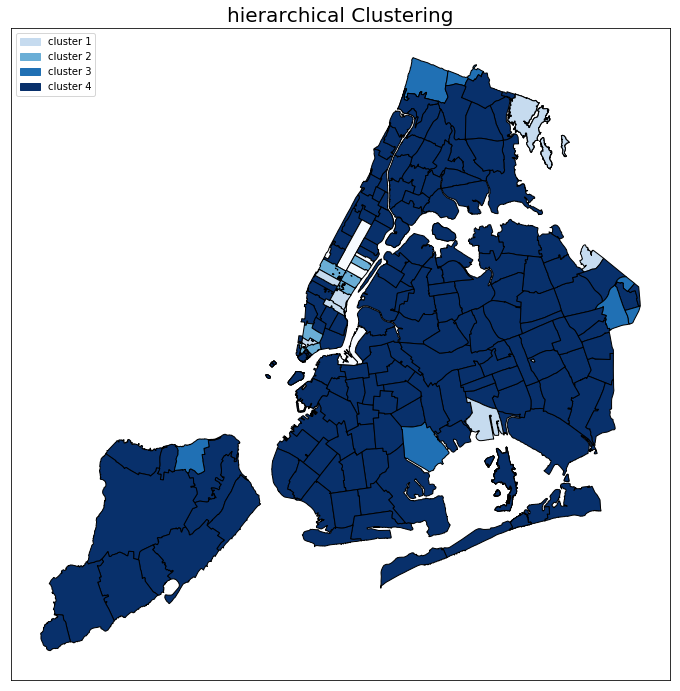

In [164]:
# plot hierarchical cluster on NYC Map
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
plot_cluster('hierarchical', 4, ax)

**Fig 5.** Hierarchical clustering map of business establishment in New York City (cluster = 4)

Each color represent different cluster. The cluster divided by most of NYC, Midtown 1, Midtown 2, upper west side, and the ones that far from downtown. 

## 6. Compare the results of the 2 algorithms

Both of the clustering method has 1 cluster that covers almost entire NYC and 1 cluster that far from downtown in Staten Islands, Bronx, Brooklyn and Queens. The only differences only in the midtown area.

## 7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 

In [167]:
NYC_standarized.head(2)

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2008,2009,2010,2011,2012,2013,2014,kmeans,agc,hierarchical
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,0.08787,-0.117160,...,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853,1,0,4
11213,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,-0.15058,0.060232,...,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875,1,0,4


From the map, I would like to name the cluster based on business establishment trends.
In K-means cluster, cluster no 1, the ones that far from city center was having downfall before the steep up in the future year, it shows they have been struggling before come to the right track. The cluster number 2, which cover most NYC area show a steadily increase each year, and I would like to call it as emerging business estblishment. The cluster number 3 and number 4 which mostly located in Midtown, shows a fluctuate trend.

Points: 10